In [2]:
# %% [markdown]
# # Figure 2: The Fundamental Scaling Law of Active Auditing
# 
# This notebook visualizes the sample complexity of **Active Auditing** versus **Passive Sampling**.
# 
# **Theoretical Context:**
# According to Theorem 12, Active Auditing should achieve a sample complexity of:
# $$ N \sim d \sigma^2 \gamma^{-2} \log(1/\delta) $$
# 
# We expect to see the **Active** strategy error rate drop exponentially faster (steep curve) compared to the **Passive** strategy (flat/slow curve).

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# %% [markdown]
# ## 1. Load Experimental Data

# %%
# Define paths relative to the notebook location
DATA_PATH = "../results/tables/exp1_scaling_law.csv"
FIG_PATH = "../results/figures"

# Ensure output directory exists
os.makedirs(FIG_PATH, exist_ok=True)

# Load data
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}. Please run 'experiments/run_scaling_exp.py' first.")

df = pd.read_csv(DATA_PATH)

print(f"Loaded {len(df)} trials.")
df.head()



Loaded 2800 trials.


,queries,method,correct,error
0,20,Passive,False,1
1,20,Active,False,1
2,30,Passive,False,1
3,30,Active,False,1
4,40,Passive,False,1


Figure saved to: ../results/figures/scaling_law_clean_dense.pdf


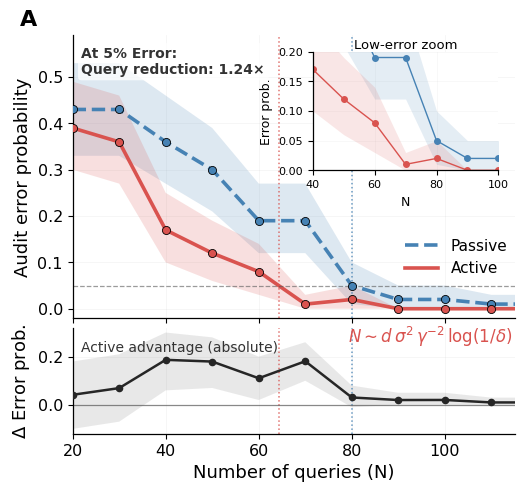

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

# -------------------------
# Paths / load
# -------------------------
DATA_PATH = "../results/tables/exp1_scaling_law.csv"
FIG_PATH  = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

req = {"queries", "error", "method"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

# -------------------------
# Nature-style rcParams
# -------------------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 13,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# -------------------------
# Bootstrap 95% CI of the mean
# -------------------------
def bootstrap_ci_mean(y, n_boot=2000, ci=95, seed=123):
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return np.nan, np.nan, np.nan
    mean = float(np.mean(y))
    if y.size == 1:
        return mean, mean, mean
    rng = np.random.default_rng(seed)
    boots = rng.choice(y, size=(n_boot, y.size), replace=True).mean(axis=1)
    alpha = (100 - ci) / 2.0
    lo = float(np.percentile(boots, alpha))
    hi = float(np.percentile(boots, 100 - alpha))
    return mean, lo, hi

def bootstrap_ci_diff(y_passive, y_active, n_boot=2000, ci=95, seed=321):
    y_passive = np.asarray(y_passive, dtype=float)
    y_active  = np.asarray(y_active, dtype=float)
    y_passive = y_passive[np.isfinite(y_passive)]
    y_active  = y_active[np.isfinite(y_active)]
    if y_passive.size == 0 or y_active.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    boots = []
    for _ in range(n_boot):
        mp = rng.choice(y_passive, size=y_passive.size, replace=True).mean()
        ma = rng.choice(y_active,  size=y_active.size,  replace=True).mean()
        boots.append(mp - ma)
    boots = np.asarray(boots, dtype=float)
    mean = float(np.mean(boots))
    alpha = (100 - ci) / 2.0
    lo = float(np.percentile(boots, alpha))
    hi = float(np.percentile(boots, 100 - alpha))
    return mean, lo, hi

def crossing_x(x, y, thr):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    if x.size < 2:
        return np.nan
    order = np.argsort(x)
    x, y = x[order], y[order]
    below = y <= thr
    if not np.any(below):
        return np.nan
    idx = int(np.argmax(below))  # first True
    if idx == 0:
        return float(x[0])
    x0, x1 = float(x[idx - 1]), float(x[idx])
    y0, y1 = float(y[idx - 1]), float(y[idx])
    if y1 == y0:
        return float(x1)
    return float(x0 + (thr - y0) * (x1 - x0) / (y1 - y0))

# -------------------------
# assume you already have:
# df (raw), summ (columns: method, queries, mean, lo, hi, n)
# method_order, PALETTE, LINESTYLE
# -------------------------


# -------------------------
# Summaries
# -------------------------
rows = []
for (method, q), sub in df.groupby(["method", "queries"], dropna=False):
    mean, lo, hi = bootstrap_ci_mean(sub["error"].values, n_boot=2000, ci=95, seed=123)
    rows.append({"method": method, "queries": float(q), "mean": mean, "lo": lo, "hi": hi, "n": len(sub)})
summ = pd.DataFrame(rows)

methods = list(summ["method"].dropna().unique())
preferred = ["Passive", "Active"]
method_order = [m for m in preferred if m in methods] + [m for m in sorted(methods) if m not in preferred]

PALETTE = {"Active": "#D9534F", "Passive": "#4682B4"}
LINESTYLE = {"Active": "-", "Passive": "--"}



# ----- build advantage summary over queries from raw df -----
adv_rows = []
for q, subq in df.groupby("queries", dropna=False):
    if ("Passive" not in subq["method"].values) or ("Active" not in subq["method"].values):
        continue
    y_p = subq.loc[subq["method"] == "Passive", "error"].values
    y_a = subq.loc[subq["method"] == "Active",  "error"].values
    mean, lo, hi = bootstrap_ci_diff(y_p, y_a, n_boot=2000, ci=95, seed=123 + int(float(q)))
    adv_rows.append({"queries": float(q), "mean": mean, "lo": lo, "hi": hi})
adv = pd.DataFrame(adv_rows).sort_values("queries")

# -------------------------
# Plot: main + advantage panel
# -------------------------
fig = plt.figure(figsize=(5.2, 4.8))
gs = GridSpec(2, 1, height_ratios=[3.2, 1.2], hspace=0.05)

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax)

# light grid
for a in [ax, ax2]:
    a.grid(True, which="major", linewidth=0.6, alpha=0.12)
    a.set_axisbelow(True)

# main curves + CI
for method in method_order:
    sub = summ[summ["method"] == method].sort_values("queries")
    x = sub["queries"].to_numpy()
    y = sub["mean"].to_numpy()
    lo = sub["lo"].to_numpy()
    hi = sub["hi"].to_numpy()

    c = PALETTE.get(method, "#333333")
    ls = LINESTYLE.get(method, "-")

    ax.fill_between(x, lo, hi, color=c, alpha=0.18, linewidth=0)
    ax.plot(x, y, linewidth=2.6, linestyle=ls, color=c, label=method)
    ax.scatter(x, y, s=34, color=c, edgecolor="black", linewidth=0.6, zorder=3)

# threshold line + crossing annotation
thr = 0.05
ax.axhline(thr, color="0.35", linestyle="--", linewidth=0.9, alpha=0.6)

thr_x = {}
for method in ["Active", "Passive"]:
    sub = summ[summ["method"] == method].sort_values("queries")
    thr_x[method] = crossing_x(sub["queries"].to_numpy(), sub["mean"].to_numpy(), thr)

for method in ["Active", "Passive"]:
    x_cross = thr_x.get(method, np.nan)
    if np.isfinite(x_cross):
        ax.axvline(x_cross, color=PALETTE.get(method, "0.2"), linestyle=":", linewidth=1.1, alpha=0.8)
        ax2.axvline(x_cross, color=PALETTE.get(method, "0.2"), linestyle=":", linewidth=1.1, alpha=0.8)

# compact text block (top-left, no overlap)
if np.isfinite(thr_x.get("Active", np.nan)) and np.isfinite(thr_x.get("Passive", np.nan)) and thr_x["Active"] > 0:
    speedup = thr_x["Passive"] / thr_x["Active"]
    ax.text(
        0.02, 0.96,
        f"At 5% Error:\n"
        f"Query reduction: {speedup:.2f}×",
        transform=ax.transAxes,
        fontsize=10,
        color="0.2",
        va="top",
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.75),
    )

# legend
ax.legend(frameon=False, loc="lower left", bbox_to_anchor=(0.72, 0.1),handlelength=2.2, fontsize=11)

# axes labels and limits
ax.set_ylabel("Audit error probability")
ax2.set_xlabel("Number of queries (N)")
ax2.set_ylabel("$\\Delta$ Error prob.")

# focus x-range to the informative region (avoids emptiness)
xmin, xmax = float(summ["queries"].min()), float(summ["queries"].max())
x_focus = np.nanmax([thr_x.get("Active", np.nan), thr_x.get("Passive", np.nan)])
if np.isfinite(x_focus):
    ax.set_xlim(xmin, min(xmax, x_focus + 35))
else:
    ax.set_xlim(xmin, xmax)

# y-lims
ymax = float(np.nanmax(summ["hi"].to_numpy()))
ax.set_ylim(-0.02, min(1.0, ymax + 0.06))

# advantage panel (absolute gain)
if not adv.empty:
    x = adv["queries"].to_numpy()
    y = adv["mean"].to_numpy()
    lo = adv["lo"].to_numpy()
    hi = adv["hi"].to_numpy()

    ax2.fill_between(x, lo, hi, color="0.15", alpha=0.10, linewidth=0)
    ax2.plot(x, y, linewidth=1.8, color="0.15")
    ax2.scatter(x, y, s=20, color="0.15", zorder=3)

ax2.axhline(0.0, color="0.35", linewidth=0.9, alpha=0.7)
ax2.text(0.02, 0.88, "Active advantage (absolute)", transform=ax2.transAxes, fontsize=10.0, color="0.2", va="top")

# remove top x tick labels
plt.setp(ax.get_xticklabels(), visible=False)

# small theory note outside the data region (bottom right)
fig.text(0.65, 0.30, r"$N \sim d\,\sigma^2\,\gamma^{-2}\,\log(1/\delta)$", fontsize=12.0, color= "#D9534F", fontweight="bold")

# -------------------------
# zoom inset for low-error tail (optional, clean)
# -------------------------
# only add if there are points near 0
y_min_all = float(np.nanmin(summ["mean"].to_numpy()))
if y_min_all < 0.08:
    axz = inset_axes(ax, width="42%", height="42%", loc="upper right", borderpad=0.9)
    axz.grid(True, which="major", linewidth=0.5, alpha=0.12)
    axz.set_axisbelow(True)

    for method in method_order:
        sub = summ[summ["method"] == method].sort_values("queries")
        x = sub["queries"].to_numpy()
        y = sub["mean"].to_numpy()
        lo = sub["lo"].to_numpy()
        hi = sub["hi"].to_numpy()
        c = PALETTE.get(method, "#333333")
        axz.fill_between(x, lo, hi, color=c, alpha=0.14, linewidth=0)
        axz.plot(x, y, marker="o", markersize=4, linewidth=1, color=c)

    # zoom window (tail)
    axz.set_xlim(40, x_focus + 20 if np.isfinite(x_focus) else xmax)
    axz.set_ylim(0.0, 0.2)
    axz.set_xlabel("N", fontsize=9)
    axz.set_ylabel("Error prob.", fontsize=9)
    axz.tick_params(axis="both", labelsize=8)
    axz.spines.top.set_visible(False)
    axz.spines.right.set_visible(False)
    axz.set_title("Low-error zoom", fontsize=9.5, color="black", pad=2.0)

# final layout
fig.subplots_adjust(left=0.12, right=0.97, bottom=0.11, top=0.94)

ax.text(-0.12, 1.02, "A", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

save_path = os.path.join(FIG_PATH, "scaling_law_clean_dense.pdf")
fig.savefig(save_path, format="pdf")
print(f"Figure saved to: {save_path}")
plt.show()


